In [89]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas.tseries.offsets import BDay

# 데이터를 불러옵니다.
kse = yf.Ticker("^KS11")
sp = yf.Ticker("^GSPC")
# KOSPI와 S&P 500 데이터를 가져옵니다.
kospi = kse.history(start="2024-01-01", end="2024-10-08")
snp = sp.history(start="2024-01-01", end="2024-10-08")

# 시간 정보를 제외하고 날짜만 추출 (index의 시간 제거)
kospi.index = kospi.index.date
snp.index = snp.index.date

# S&P 500의 날짜를 영업일 기준으로 하루 뒤로 이동
snp['Date_shifted'] = snp.index + BDay(1)
snp= snp.set_index('Date_shifted')

#s&p 500 에프터장과 ,프리마켓장 보정

snp['Yday_Close']= snp['Close'].shift(1)

snp['close_rise']= np.where(snp['Close']-snp['Yday_Close']>0,1,0)

#kospi 에프터장과 ,프리마켓장 보정

kospi['Yday_Close'] = kospi['Close'].shift(1)

# 오늘의 Close_snp와 다음날 Close_snp의 차이를 계산하여 양수면 1, 아니면 0으로 설정
kospi['close_rise'] = np.where(kospi['Close'] - kospi['Yday_Close'] > 0, 1, 0)


# 두 시장이 모두 열린 날만 포함하는 inner join 수행
merged_data = pd.merge(kospi, snp, left_index=True, right_index=True, suffixes=('_kospi', '_snp'), how='inner')

# 상승/하락 여부 계산
merged_data['kospi_rise'] = np.where(merged_data['Close_kospi'] > merged_data['Open_kospi'], 1, 0)
merged_data['snp_rise'] = np.where(merged_data['Close_snp'] > merged_data['Open_snp'], 1, 0)

# 상관관계 계산
correlation = merged_data[['kospi_rise', 'snp_rise']].corr()
y_correlation=merged_data[['close_rise_kospi', 'close_rise_snp']].corr()

# 상관관계 출력
print("Correlation between KOSPI rise and S&P 500 rise:")
print(y_correlation)




Correlation between KOSPI rise and S&P 500 rise:
                  close_rise_kospi  close_rise_snp
close_rise_kospi          1.000000        0.323438
close_rise_snp            0.323438        1.000000


/var/folders/mv/kwm2lnj57ys03y_sg71d63f40000gn/T/ipykernel_1512/1333425260.py:18: FutureWarning: Setting an Index with object dtype into a DataFrame will stop inferring another dtype in a future version. Cast the Index explicitly before setting it into the DataFrame.
  snp['Date_shifted'] = snp.index + BDay(1)


In [87]:
#사전 확률




# snp_rise가 0인 경우 필터링 (S&P 500이 하락한 경우)
snp_down = merged_data[merged_data['close_rise_snp'] == 1]

# 그 중에서 kospi_rise가 0인 경우 (KOSPI도 하락한 경우) 비율을 계산
p_kospi_down_given_snp_down = (snp_down['close_rise_kospi'] == 1).mean()

# 확률 출력
print(f"P(kospi_rise=0 | snp_rise=0): {p_kospi_down_given_snp_down:.4f}")


P(kospi_rise=0 | snp_rise=0): 0.6734


In [12]:
kospi_volume_mean = merged_data['Volume_kospi'].mean()
snp_volume_mean = merged_data['Volume_snp'].mean()

print(f"KOSPI Volume 평균: {kospi_volume_mean}")
print(f"S&P 500 Volume 평균: {snp_volume_mean}")


KOSPI Volume 평균: 725041.5630550622
S&P 500 Volume 평균: 4409293081.705151


In [76]:
kospi['Volume_MA'] = kospi['Volume'].rolling(window=15).mean()

# 이동 평균의 기울기(변화율) 계산 (shift 사용)
kospi['Volume_MA_slope'] = kospi['Volume_MA'].diff()

# 거래량의 상승/하락 여부 계산 (기울기가 양수면 상승, 음수면 하락)
kospi['Volume_trend'] = np.where(kospi['Volume_MA_slope'] > 0, '상승', '하락')

In [80]:
real_kospi

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume_MA,Volume_MA_slope,Volume_trend
2020-01-02,2201.209961,2202.320068,2171.840088,2175.169922,494700,0.0,0.0,508580.000000,183.333333,상승
2020-01-03,2192.580078,2203.379883,2165.389893,2176.459961,631600,0.0,0.0,502070.000000,-6510.000000,하락
2020-01-06,2154.969971,2164.419922,2149.949951,2155.070068,592700,0.0,0.0,502456.666667,386.666667,상승
2020-01-07,2166.600098,2181.620117,2164.270020,2175.540039,568200,0.0,0.0,502076.666667,-380.000000,하락
2020-01-08,2156.270020,2162.320068,2137.719971,2151.310059,913800,0.0,0.0,515206.666667,13130.000000,상승
...,...,...,...,...,...,...,...,...,...,...
2024-09-27,2674.580078,2681.449951,2649.780029,2649.780029,413000,0.0,0.0,359186.666667,3996.666667,상승
2024-09-30,2665.239990,2668.659912,2593.270020,2593.270020,358900,0.0,0.0,358533.333333,-653.333333,하락
2024-10-02,2566.550049,2591.610107,2555.459961,2561.689941,351000,0.0,0.0,359276.666667,743.333333,상승
2024-10-04,2563.699951,2585.590088,2555.570068,2569.709961,414300,0.0,0.0,360223.333333,946.666667,상승


In [79]:
kospi.index = pd.to_datetime(kospi.index)
real_kospi = kospi[kospi.index > pd.Timestamp('2020-01-01')]

In [60]:
# 이동 평균을 계산하고, 초반 NaN 값을 전체 평균으로 대체
kospi['Volume_MA'] = kospi['Volume'].rolling(window=30).mean()
kospi['Volume_MA'].fillna(kospi['Volume'].mean(), inplace=True)  # NaN을 전체 평균으로 채우기


/var/folders/mv/kwm2lnj57ys03y_sg71d63f40000gn/T/ipykernel_1512/3043625153.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  kospi['Volume_MA'].fillna(kospi['Volume'].mean(), inplace=True)  # NaN을 전체 평균으로 채우기


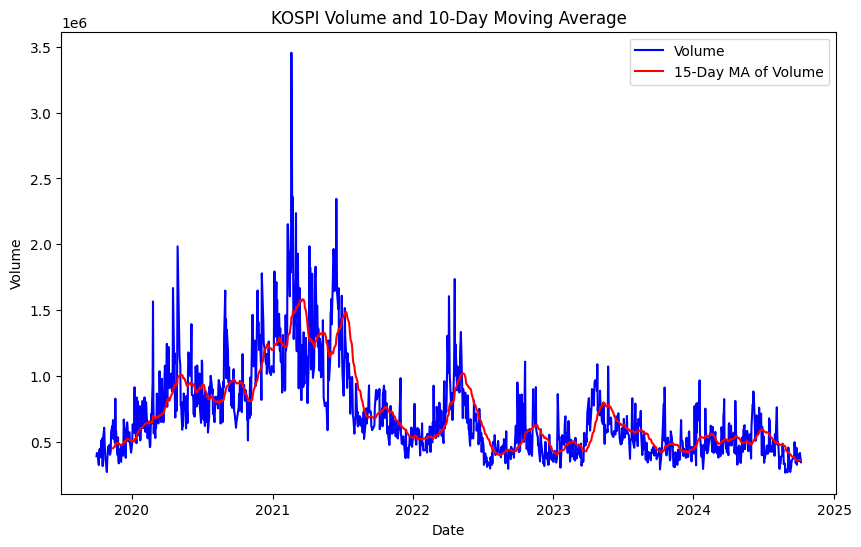

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# 원본 거래량(Volume) 그래프
plt.plot(kospi.index, kospi['Volume'], label='Volume', color='blue')

# 이동 평균(MA) 그래프
plt.plot(kospi.index, kospi['Volume_MA'], label='15-Day MA of Volume', color='red')

# 제목과 레이블 설정
plt.title('KOSPI Volume and 10-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Volume')

# 범례 추가
plt.legend()

# 그래프 출력
plt.show()


In [81]:
snp_data = snp.history(start="2020-01-01", end="2024-10-08")

In [82]:
snp_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,3244.669922,3258.139893,3235.530029,3257.850098,3459930000,0.0,0.0
2020-01-03 00:00:00-05:00,3226.360107,3246.149902,3222.340088,3234.850098,3484700000,0.0,0.0
2020-01-06 00:00:00-05:00,3217.550049,3246.840088,3214.639893,3246.280029,3702460000,0.0,0.0
2020-01-07 00:00:00-05:00,3241.860107,3244.909912,3232.429932,3237.179932,3435910000,0.0,0.0
2020-01-08 00:00:00-05:00,3238.590088,3267.070068,3236.669922,3253.050049,3726840000,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-01 00:00:00-04:00,5757.729980,5757.729980,5681.279785,5708.750000,4025180000,0.0,0.0
2024-10-02 00:00:00-04:00,5698.140137,5719.629883,5674.000000,5709.540039,3829050000,0.0,0.0
2024-10-03 00:00:00-04:00,5698.189941,5718.779785,5677.370117,5699.939941,3597450000,0.0,0.0


In [144]:
import pandas as pd
import numpy as np
import yfinance as yf

k=yf.Ticker("^KS11")
kse=k.history(start="2024-01-01",end="2024-10-10")
kse["np"]=np.where(kse["Close"]-kse["Open"]>0,1,-1)

In [136]:
kse

,Open,High,Low,Close,Volume,Dividends,Stock Splits,np
Date,,,,,,,,
2024-01-02 00:00:00+09:00,2645.469971,2675.800049,2641.879883,2669.810059,409900,0.0,0.0,1
2024-01-03 00:00:00+09:00,2643.540039,2643.719971,2607.310059,2607.310059,463100,0.0,0.0,-1
2024-01-04 00:00:00+09:00,2592.439941,2602.639893,2580.090088,2587.020020,770200,0.0,0.0,-1
2024-01-05 00:00:00+09:00,2586.889893,2592.290039,2572.600098,2578.080078,520500,0.0,0.0,-1
2024-01-08 00:00:00+09:00,2584.229980,2591.679932,2566.340088,2567.820068,320100,0.0,0.0,-1
...,...,...,...,...,...,...,...,...
2024-09-30 00:00:00+09:00,2665.239990,2668.659912,2593.270020,2593.270020,358900,0.0,0.0,-1
2024-10-02 00:00:00+09:00,2566.550049,2591.610107,2555.459961,2561.689941,351000,0.0,0.0,-1
2024-10-04 00:00:00+09:00,2563.699951,2585.590088,2555.570068,2569.709961,414300,0.0,0.0,1


In [160]:
doji_condtion=(np.abs(kse['Open']-kse['Close'])<=(kse['High']-kse['Low'])*0.1 )|(
   np.abs(kse['Open']-kse['Close'])<=0.001* kse['Open']
)
kse.loc[doji_condtion,'ct'] =1 


In [161]:
kiwi=kse[kse['ct']==1]


In [149]:
kaka

,Open,High,Low,Close,Volume,Dividends,Stock Splits,np,ct
Date,,,,,,,,,
2024-03-22 00:00:00+09:00,2751.149902,2763.060059,2738.179932,2748.560059,509500,0.0,0.0,-1,2.0
2024-05-14 00:00:00+09:00,2732.979980,2735.820068,2722.739990,2730.340088,443300,0.0,0.0,-1,2.0
2024-06-18 00:00:00+09:00,2765.699951,2772.350098,2759.030029,2763.919922,561500,0.0,0.0,-1,2.0
2024-07-11 00:00:00+09:00,2888.760010,2896.429932,2879.280029,2891.350098,461700,0.0,0.0,1,2.0
2024-08-30 00:00:00+09:00,2676.719971,2686.510010,2668.659912,2674.310059,278800,0.0,0.0,-1,2.0


In [162]:
kiwi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2024-01-15 00:00:00+09:00 to 2024-10-08 00:00:00+09:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24 non-null     float64
 1   High          24 non-null     float64
 2   Low           24 non-null     float64
 3   Close         24 non-null     float64
 4   Volume        24 non-null     int64  
 5   Dividends     24 non-null     float64
 6   Stock Splits  24 non-null     float64
 7   np            24 non-null     int64  
 8   ct            24 non-null     float64
dtypes: float64(7), int64(2)
memory usage: 1.9 KB


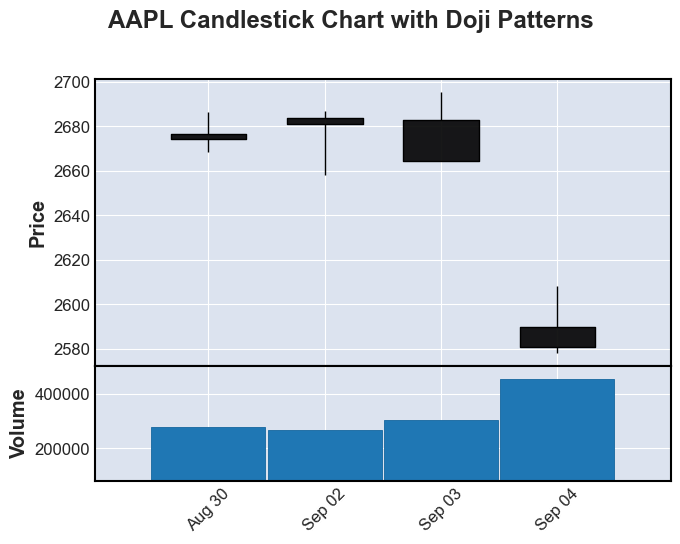

In [159]:
import pandas as pd
import mplfinance as mpf
import yfinance as yf

# 데이터 가져오기 (예시: 애플 주식 데이터)
ticker = yf.Ticker("^KS11")
data = ticker.history(start="2024-08-30", end="2024-09-05")

# 도지형 캔들 차트 그리기
mpf.plot(data, type='candle', volume=True, title='AAPL Candlestick Chart with Doji Patterns')


In [119]:
hammer_condition = (kse['ct'].isnull() & 
    (kse['np'] == 1) &  # 양봉일 경우
    (kse['Close'] - kse['Open'] <= 0.5 * (kse['Open'] - kse['Low'])) &  # 몸통이 짧아야 함
    (kse['Open'] - kse['Low'] > 2 * (kse['High'] - kse['Close']))  # 아랫그림자가 길어야 함
) |((kse['ct'].isnull()) &
    (kse['np'] == -1) &  # 음봉일 경우
    (kse['Open'] - kse['Close'] <= 0.5 * (kse['Close'] - kse['Low'])) &  # 몸통이 짧아야 함
    (kse['Close'] - kse['Low'] > 2 * (kse['High'] - kse['Open']))  # 아랫그림자가 길어야 함
)

kse.loc[hammer_condition,'ct']=2

In [121]:
reverse_hammer_condition = (
    (kse['ct'].isnull()) & 
    (kse['np'] == 1) &  # 양봉일 경우
    (kse['Close'] - kse['Open'] <= 0.5 * (kse['High'] - kse['Close'])) &  # 몸통이 짧아야 함
    (kse['High'] - kse['Close'] > 2 * (kse['Open'] - kse['Low']))  # 윗그림자가 길어야 함
) | (
    (kse['ct'].isnull()) &
    (kse['np'] == -1) &  # 음봉일 경우
    (kse['Open'] - kse['Close'] <= 0.5 * (kse['High'] - kse['Open'])) &  # 몸통이 짧아야 함
    (kse['High'] - kse['Open'] > 2 * (kse['Close'] - kse['Low']))  # 윗그림자가 길어야 함
)

# Reverse Hammer 패턴에 'ct' 값을 3으로 설정
kse.loc[reverse_hammer_condition, 'ct'] = 3

In [123]:
kopi_rm=kse[kse['ct']==3]

In [130]:
kopi_h=kse[kse['ct']==2]

In [96]:
kse.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 2024-01-02 00:00:00+09:00 to 2024-10-08 00:00:00+09:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          187 non-null    float64
 1   High          187 non-null    float64
 2   Low           187 non-null    float64
 3   Close         187 non-null    float64
 4   Volume        187 non-null    int64  
 5   Dividends     187 non-null    float64
 6   Stock Splits  187 non-null    float64
 7   np            187 non-null    int64  
 8   ct            46 non-null     float64
dtypes: float64(7), int64(2)
memory usage: 14.6 KB


In [124]:
kopi_rm

,Open,High,Low,Close,Volume,Dividends,Stock Splits,np,ct
Date,,,,,,,,,
2024-01-11 00:00:00+09:00,2543.030029,2557.300049,2540.270020,2540.270020,788400,0.0,0.0,-1,3.0
2024-03-05 00:00:00+09:00,2660.800049,2684.830078,2649.350098,2649.399902,457200,0.0,0.0,-1,3.0
2024-03-11 00:00:00+09:00,2665.580078,2677.209961,2658.739990,2659.840088,389800,0.0,0.0,-1,3.0
2024-07-24 00:00:00+09:00,2755.500000,2778.310059,2748.649902,2758.709961,468500,0.0,0.0,1,3.0
2024-10-02 00:00:00+09:00,2566.550049,2591.610107,2555.459961,2561.689941,351000,0.0,0.0,-1,3.0


In [132]:
kopi_h

,Open,High,Low,Close,Volume,Dividends,Stock Splits,np,ct
Date,,,,,,,,,
2024-01-19 00:00:00+09:00,2468.429932,2479.000000,2455.500000,2472.739990,518800,0.0,0.0,1,2.0
2024-01-24 00:00:00+09:00,2476.219971,2476.219971,2454.340088,2469.689941,395500,0.0,0.0,-1,2.0
2024-01-25 00:00:00+09:00,2467.729980,2474.010010,2452.360107,2470.340088,357200,0.0,0.0,1,2.0
2024-03-07 00:00:00+09:00,2653.979980,2660.260010,2633.570068,2647.620117,462900,0.0,0.0,-1,2.0
2024-04-04 00:00:00+09:00,2738.239990,2746.389893,2727.100098,2742.000000,478000,0.0,0.0,1,2.0
2024-04-15 00:00:00+09:00,2661.360107,2673.260010,2641.159912,2670.429932,562000,0.0,0.0,1,2.0
2024-04-19 00:00:00+09:00,2600.689941,2609.899902,2553.550049,2591.860107,809500,0.0,0.0,-1,2.0
2024-05-14 00:00:00+09:00,2732.979980,2735.820068,2722.739990,2730.340088,443300,0.0,0.0,-1,2.0
2024-06-28 00:00:00+09:00,2792.790039,2797.820068,2782.399902,2797.820068,610600,0.0,0.0,1,2.0


In [69]:
data

Open              2478.320068
High              2482.840088
Low               2464.239990
Close             2478.610107
Volume          472300.000000
Dividends            0.000000
Stock Splits         0.000000
np                   1.000000
ct                   2.000000
Name: 2024-01-23 00:00:00+09:00, dtype: float64